In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
     

In [2]:
df = pd.read_csv('mental_health_workplace_survey.csv')

In [3]:
df.head()


,EmployeeID,Age,Gender,Country,JobRole,Department,YearsAtCompany,WorkHoursPerWeek,RemoteWork,BurnoutLevel,...,CommuteTime,HasMentalHealthSupport,ManagerSupportScore,HasTherapyAccess,MentalHealthDaysOff,SalaryRange,WorkLifeBalanceScore,TeamSize,CareerGrowthScore,BurnoutRisk
0,1001,50,Male,UK,Sales Associate,HR,14,47,No,3.37,...,117,No,3.15,Yes,8,40K-60K,8.82,6,9.20,0
1,1002,36,Male,Germany,Software Engineer,IT,1,59,Hybrid,7.39,...,8,Yes,4.40,Yes,4,80K-100K,2.80,45,8.46,1
2,1003,29,Non-binary,India,IT Admin,IT,13,59,Hybrid,7.10,...,75,No,3.63,No,6,80K-100K,7.28,7,7.96,1
3,1004,42,Male,Australia,HR Specialist,IT,15,31,Yes,4.18,...,43,Yes,4.50,Yes,9,60K-80K,1.31,11,8.90,0
4,1005,40,Male,Brazil,Customer Support,Support,6,34,Yes,8.28,...,58,Yes,5.51,Yes,6,<40K,1.17,18,8.88,1


In [4]:
df.drop(columns = ['EmployeeID', 'Country'], inplace=True)

In [ ]:
trgt = 'StressLevel'
cat_cols = ['Gender', 'Age', 'FamilyHistory', 'WorkInterfere', 'MentalHealthConsequence', 'PhysHealthConsequence', 'Coworkers', 'Supervisor']
num_cols = ['WorkHoursPerWeek', 'SleepHours','CommuteTime', 'MentalHealthDays', 'WorkLifeBalance']

In [6]:
df['Stress_Work_Interaction'] = df['StressLevel'] * df['WorkHoursPerWeek']
df['Commute_Stress_Interaction'] = df['CommuteTime'] / (df['StressLevel'] + 1)

In [11]:
num_cols.extend(['Stress_Work_Interaction', 'Commute_Stress_Interaction'])

In [8]:
prp = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])


In [9]:
X = df.drop(columns=[trgt])
y = df[trgt]


In [12]:
# Fix column lists to match columns in X
cat_cols_fixed = [col for col in cat_cols if col in X.columns]
num_cols_fixed = [col for col in num_cols if col in X.columns]

# Update the ColumnTransformer with the fixed column lists
prp_fixed = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), num_cols_fixed),
		('cat', OneHotEncoder(), cat_cols_fixed)
	])

X_processed = prp_fixed.fit_transform(X)


In [13]:
mi_scores = mutual_info_regression(X_processed, y)
top_features_idx = np.argsort(mi_scores)[-10:]  
X_selected = X_processed[:, top_features_idx]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
model = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}


In [15]:
print("Model Performance:")
for n,m in model.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{n} - MSE: {mse:.2f}, R^2: {r2:.2f}")

Model Performance:
LinearRegression - MSE: 1.01, R^2: 0.85
Ridge - MSE: 1.01, R^2: 0.85
Lasso - MSE: 1.01, R^2: 0.85


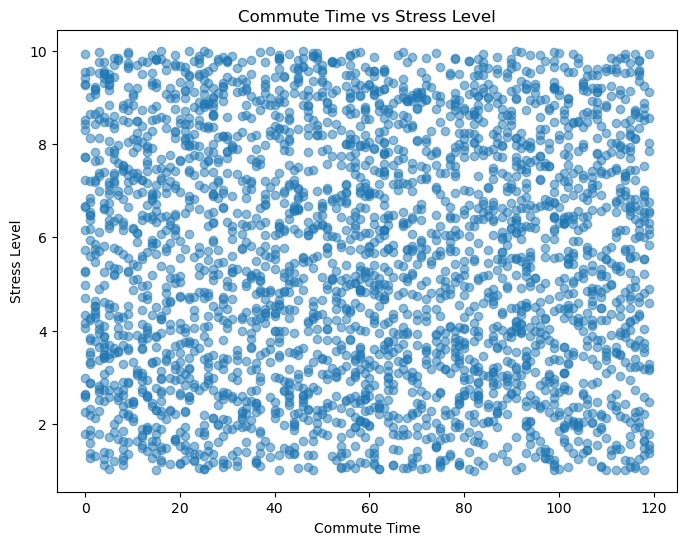

In [ ]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['CommuteTime'], y=df['StressLevel'],
                hue=df['Commute_Stress_Interaction'], palette="viridis", alpha=0.8)
plt.title("Interaction: StressLevel × CommuteTime")
plt.xlabel("Commute Time")
plt.ylabel("Stress Level")
plt.tight_layout()
plt.show()
plt.show()


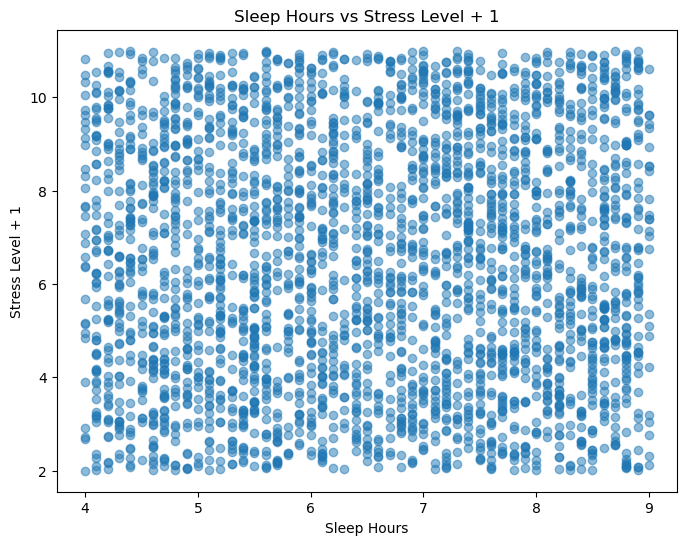

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(df['SleepHours'], df['StressLevel'] + 1, alpha=0.5)
plt.xlabel('Sleep Hours')
plt.ylabel('Stress Level + 1')
plt.title('Sleep Hours vs Stress Level + 1')
plt.show()